In [18]:
# Install necessary packages
!pip install seaborn rdkit pubchempy shap

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from rdkit import Chem
from rdkit.Chem import AllChem
from pubchempy import get_compounds
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [23]:
# Read the dataset and filter based on 'Type of MB'
dataset = pd.read_csv('Dataset.csv')
dataset = dataset[['Micro Pollutant','Initial Concentration of MP (mg/L)', 'Compound MW (g/mol)', 'Compound Charge', 'Log D (pH=6.5-7)','pKa','Initial FS pH', 'Type of MB', 'Draw Solution','DS MW (g mol-1)', 'DS Concentration (M)', 'Operating Time (h)', 'Cross Flow Velocity (cm/s)','Water Flux, Jw (LMH)','Reverse Salt Flux, Js (gMH)','Temperature (⁰C)', 'Removal Rate (%)']]
dataset = dataset[(dataset['Type of MB'] == 'HTI CTA FO') | (dataset['Type of MB'] == 'HTI PA FO') | (dataset['Type of MB'] == 'Aquaporin FO')]

Micro_Pollutant=dataset['Micro Pollutant']
DS=dataset['Draw Solution']

# Function to retrieve SMILES given a compound name with retries
def get_smiles_with_retries(compound_name, max_retries=3, retry_delay=5):
    retries = 0
    while retries < max_retries:
        try:
            compounds = get_compounds(compound_name, 'name')
            return compounds[0].canonical_smiles if compounds else None
        except Exception as e:
            print(f"Error retrieving SMILES for {compound_name}: {e}")
            retries += 1
            time.sleep(retry_delay)
    return None

# Add SMILES column to the dataset with retries
dataset['SMILES_MP'] = Micro_Pollutant.apply(lambda x: get_smiles_with_retries(x))
dataset['SMILES_DS'] = DS.apply(lambda x: get_smiles_with_retries(x))




In [20]:
dataset

,Micro Pollutant,Initial Concentration of MP (mg/L),Compound MW (g/mol),Compound Charge,Log D (pH=6.5-7),pKa,Initial FS pH,Type of MB,Draw Solution,DS MW (g mol-1),DS Concentration (M),Operating Time (h),Cross Flow Velocity (cm/s),"Water Flux, Jw (LMH)","Reverse Salt Flux, Js (gMH)",Temperature (⁰C),Removal Rate (%),SMILES_MP,SMILES_DS
0,Atenolol,0.01,266.34,1,-2.09,9.60,7.05,HTI CTA FO,Monoammonium Phosphate,115.00,1.0,10.0,8.5,7.7,0.08,20.0,79.80,CC(C)NCC(COC1=CC=C(C=C1)CC(=O)N)O,[NH4+].OP(=O)(O)[O-]
1,Atrazine,0.01,216.00,0,2.64,2.27,7.05,HTI CTA FO,Monoammonium Phosphate,115.00,1.0,10.0,8.5,7.7,0.08,20.0,76.90,CCNC1=NC(=NC(=N1)Cl)NC(C)C,[NH4+].OP(=O)(O)[O-]
2,Primidone,0.01,218.00,0,0.83,12.26,7.05,HTI CTA FO,Monoammonium Phosphate,115.00,1.0,10.0,8.5,7.7,0.08,20.0,89.90,CCC1(C(=O)NCNC1=O)C2=CC=CC=C2,[NH4+].OP(=O)(O)[O-]
3,Caffeine,0.01,194.00,0,-0.63,0.52,7.05,HTI CTA FO,Monoammonium Phosphate,115.00,1.0,10.0,8.5,7.7,0.08,20.0,81.30,CN1C=NC2=C1C(=O)N(C(=O)N2C)C,[NH4+].OP(=O)(O)[O-]
4,Atenolol,0.01,266.34,1,-2.09,9.60,7.05,HTI CTA FO,Monoammonium Phosphate,115.00,2.0,10.0,8.5,9.5,0.08,20.0,79.80,CC(C)NCC(COC1=CC=C(C=C1)CC(=O)N)O,[NH4+].OP(=O)(O)[O-]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,Sulfamethoxazole,0.25,253.30,-1,-0.22,1.39,5.50,HTI CTA FO,NaCl,58.44,1.0,1.0,9.0,NaN,NaN,23.0,81.70,CC1=CC(=NO1)NS(=O)(=O)C2=CC=C(C=C2)N,[Na+].[Cl-]
637,Carbamazepine,0.25,236.30,0,1.89,9.73,6.50,HTI CTA FO,NaCl,58.44,1.0,1.0,9.0,NaN,NaN,23.0,90.65,C1=CC=C2C(=C1)C=CC3=CC=CC=C3N2C(=O)N,[Na+].[Cl-]
638,Sulfamethoxazole,0.25,253.30,-1,-0.22,1.39,6.50,HTI CTA FO,NaCl,58.44,1.0,1.0,9.0,NaN,NaN,23.0,93.30,CC1=CC(=NO1)NS(=O)(=O)C2=CC=C(C=C2)N,[Na+].[Cl-]
639,Carbamazepine,0.25,236.30,0,1.89,9.73,7.50,HTI CTA FO,NaCl,58.44,1.0,1.0,9.0,NaN,NaN,23.0,95.65,C1=CC=C2C(=C1)C=CC3=CC=CC=C3N2C(=O)N,[Na+].[Cl-]


In [21]:
# Generating Molecular Fingerprints of MP and DS

# Convert the 'SMILES_DS' column to RDKit Mol objects
dataset['Molecule_DS'] = dataset['SMILES_DS'].apply(Chem.MolFromSmiles)

# Generate molecular fingerprints for DS
dataset['Fingerprint_DS'] = dataset['Molecule_DS'].apply(lambda x: AllChem.RDKFingerprint(x))

# Convert DS fingerprints to a binary representation
dataset['Fingerprint_Bits_DS'] = dataset['Fingerprint_DS'].apply(lambda x: x.ToBitString())

# Convert the 'SMILES_MP' column to RDKit Mol objects
dataset['Molecule_MP'] = dataset['SMILES_MP'].apply(Chem.MolFromSmiles)

# Generate molecular fingerprints for MP
dataset['Fingerprint_MP'] = dataset['Molecule_MP'].apply(lambda x: AllChem.RDKFingerprint(x))

# Convert MP fingerprints to a binary representation
dataset['Fingerprint_Bits_MP'] = dataset['Fingerprint_MP'].apply(lambda x: x.ToBitString())

# Split both DS and MP fingerprint bits and create separate columns for each bit
for i in range(len(dataset['Fingerprint_Bits_DS'][0])):
    dataset[f'DS_Bit_{i}'] = dataset['Fingerprint_Bits_DS'].apply(lambda x: int(x[i]))

for i in range(len(dataset['Fingerprint_Bits_MP'][0])):
    dataset[f'MP_Bit_{i}'] = dataset['Fingerprint_Bits_MP'].apply(lambda x: int(x[i]))

# Calculate variance for each DS bit column
ds_bit_columns = [f'DS_Bit_{i}' for i in range(len(dataset['Fingerprint_Bits_DS'][0]))]
ds_bit_variances = dataset[ds_bit_columns].var()

# Calculate variance for each MP bit column
mp_bit_columns = [f'MP_Bit_{i}' for i in range(len(dataset['Fingerprint_Bits_MP'][0]))]
mp_bit_variances = dataset[mp_bit_columns].var()

# Set a threshold for low variance (you can adjust this threshold)
low_variance_threshold = 0.1

# Identify DS columns with low variance
low_variance_columns_ds = ds_bit_variances[ds_bit_variances < low_variance_threshold].index

# Identify MP columns with low variance
low_variance_columns_mp = mp_bit_variances[mp_bit_variances < low_variance_threshold].index

# Drop columns with low variance for DS and MP
dataset.drop(low_variance_columns_ds, axis=1, inplace=True)
dataset.drop(low_variance_columns_mp, axis=1, inplace=True)
dataset.drop(columns=['Micro Pollutant','Draw Solution' ,'SMILES_MP','SMILES_DS', 'Molecule_MP','Molecule_DS','Fingerprint_Bits_MP','Fingerprint_Bits_DS','Fingerprint_MP','Fingerprint_DS'], inplace=True)
dataset.dropna(subset=['Removal Rate (%)'], inplace=True)
dataset = pd.get_dummies(dataset, columns=['Type of MB'], prefix='MB', drop_first=True)
X = dataset.drop(columns=['Removal Rate (%)']) # Features (all columns except the target)
y = dataset['Removal Rate (%)']

# Retrieve the feature names before scaling
feature_names = X.columns

dataset

TypeError: No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type NoneType

In [7]:
# SMILES NaNs Removed Option

import pandas as pd
import time
from pubchempy import get_compounds
from rdkit import Chem
from rdkit.Chem import AllChem

# Read the dataset and filter based on 'Type of MB'
dataset = pd.read_csv('Dataset.csv')
dataset = dataset[['Micro Pollutant','Initial Concentration of MP (mg/L)', 'Compound MW (g/mol)', 'Compound Charge', 'Log D (pH=6.5-7)','pKa','Initial FS pH', 'Type of MB', 'Draw Solution','DS MW (g mol-1)', 'DS Concentration (M)', 'Operating Time (h)', 'Cross Flow Velocity (cm/s)','Water Flux, Jw (LMH)','Reverse Salt Flux, Js (gMH)','Temperature (⁰C)', 'Removal Rate (%)']]
dataset = dataset[(dataset['Type of MB'] == 'HTI CTA FO') | (dataset['Type of MB'] == 'HTI PA FO') | (dataset['Type of MB'] == 'Aquaporin FO')]

Micro_Pollutant = dataset['Micro Pollutant']
DS = dataset['Draw Solution']

# Local cache to store retrieved SMILES
smiles_cache = {}

# Function to retrieve SMILES given a compound name with retries
def get_smiles_with_retries(compound_name, max_retries=5, retry_delay=10):
    if compound_name in smiles_cache:
        return smiles_cache[compound_name]

    retries = 0
    while retries < max_retries:
        try:
            compounds = get_compounds(compound_name, 'name')
            smiles = compounds[0].canonical_smiles if compounds else None
            if smiles:
                smiles_cache[compound_name] = smiles
            return smiles
        except Exception as e:
            print(f"Error retrieving SMILES for {compound_name}: {e}")
            retries += 1
            time.sleep(retry_delay)
    return None

# Add SMILES column to the dataset with retries, with batch processing
batch_size = 10
for start in range(0, len(dataset), batch_size):
    end = start + batch_size
    print(f"Processing batch {start} to {end}")
    dataset.loc[start:end, 'SMILES_MP'] = dataset.loc[start:end, 'Micro Pollutant'].apply(lambda x: get_smiles_with_retries(x))
    dataset.loc[start:end, 'SMILES_DS'] = dataset.loc[start:end, 'Draw Solution'].apply(lambda x: get_smiles_with_retries(x))
    time.sleep(5)  # Delay between batches

# Save the cache to a file for future use (optional)
import pickle
with open('smiles_cache.pkl', 'wb') as f:
    pickle.dump(smiles_cache, f)

# Filter out rows where SMILES could not be retrieved
dataset = dataset.dropna(subset=['SMILES_MP', 'SMILES_DS'])

# Generating Molecular Fingerprints of MP and DS
# Convert the 'SMILES_DS' column to RDKit Mol objects
dataset['Molecule_DS'] = dataset['SMILES_DS'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notnull(x) else None)

# Generate molecular fingerprints for DS
dataset['Fingerprint_DS'] = dataset['Molecule_DS'].apply(lambda x: AllChem.RDKFingerprint(x) if x else None)

# Convert DS fingerprints to a binary representation
dataset['Fingerprint_Bits_DS'] = dataset['Fingerprint_DS'].apply(lambda x: x.ToBitString() if x else None)

# Convert the 'SMILES_MP' column to RDKit Mol objects
dataset['Molecule_MP'] = dataset['SMILES_MP'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notnull(x) else None)

# Generate molecular fingerprints for MP
dataset['Fingerprint_MP'] = dataset['Molecule_MP'].apply(lambda x: AllChem.RDKFingerprint(x) if x else None)

# Convert MP fingerprints to a binary representation
dataset['Fingerprint_Bits_MP'] = dataset['Fingerprint_MP'].apply(lambda x: x.ToBitString() if x else None)

# Filter out rows where fingerprints could not be generated
dataset = dataset.dropna(subset=['Fingerprint_Bits_DS', 'Fingerprint_Bits_MP'])

# Split both DS and MP fingerprint bits and create separate columns for each bit
for i in range(len(dataset['Fingerprint_Bits_DS'].iloc[0])):
    dataset[f'DS_Bit_{i}'] = dataset['Fingerprint_Bits_DS'].apply(lambda x: int(x[i]))

for i in range(len(dataset['Fingerprint_Bits_MP'].iloc[0])):
    dataset[f'MP_Bit_{i}'] = dataset['Fingerprint_Bits_MP'].apply(lambda x: int(x[i]))

# Calculate variance for each DS bit column
ds_bit_columns = [f'DS_Bit_{i}' for i in range(len(dataset['Fingerprint_Bits_DS'].iloc[0]))]
ds_bit_variances = dataset[ds_bit_columns].var()

# Calculate variance for each MP bit column
mp_bit_columns = [f'MP_Bit_{i}' for i in range(len(dataset['Fingerprint_Bits_MP'].iloc[0]))]
mp_bit_variances = dataset[mp_bit_columns].var()

# Set a threshold for low variance (you can adjust this threshold)
low_variance_threshold = 0.1

# Identify DS columns with low variance
low_variance_columns_ds = ds_bit_variances[ds_bit_variances < low_variance_threshold].index

# Identify MP columns with low variance
low_variance_columns_mp = mp_bit_variances[mp_bit_variances < low_variance_threshold].index

# Drop columns with low variance for DS and MP
dataset.drop(low_variance_columns_ds, axis=1, inplace=True)
dataset.drop(low_variance_columns_mp, axis=1, inplace=True)
dataset.drop(columns=['Micro Pollutant','Draw Solution' ,'SMILES_MP','SMILES_DS', 'Molecule_MP','Molecule_DS','Fingerprint_Bits_MP','Fingerprint_Bits_DS','Fingerprint_MP','Fingerprint_DS'], inplace=True)
dataset.dropna(subset=['Removal Rate (%)'], inplace=True)
dataset = pd.get_dummies(dataset, columns=['Type of MB'], prefix='MB', drop_first=True)

X = dataset.drop(columns=['Removal Rate (%)'])  # Features (all columns except the target)
y = dataset['Removal Rate (%)']

# Retrieve the feature names before scaling
feature_names = X.columns

dataset.head()


Processing batch 0 to 10
Processing batch 10 to 20
Processing batch 20 to 30
Processing batch 30 to 40
Processing batch 40 to 50
Processing batch 50 to 60
Processing batch 60 to 70
Processing batch 70 to 80
Processing batch 80 to 90
Processing batch 90 to 100
Processing batch 100 to 110
Processing batch 110 to 120
Processing batch 120 to 130
Processing batch 130 to 140
Processing batch 140 to 150
Processing batch 150 to 160
Processing batch 160 to 170
Processing batch 170 to 180
Processing batch 180 to 190
Processing batch 190 to 200
Processing batch 200 to 210
Processing batch 210 to 220
Processing batch 220 to 230
Processing batch 230 to 240
Processing batch 240 to 250
Processing batch 250 to 260
Processing batch 260 to 270
Processing batch 270 to 280
Processing batch 280 to 290
Processing batch 290 to 300
Processing batch 300 to 310
Processing batch 310 to 320
Processing batch 320 to 330
Processing batch 330 to 340
Processing batch 340 to 350
Processing batch 350 to 360
Processing b

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

,Initial Concentration of MP (mg/L),Compound MW (g/mol),Compound Charge,Log D (pH=6.5-7),pKa,Initial FS pH,DS MW (g mol-1),DS Concentration (M),Operating Time (h),Cross Flow Velocity (cm/s),...,MP_Bit_2035,MP_Bit_2037,MP_Bit_2038,MP_Bit_2040,MP_Bit_2041,MP_Bit_2043,MP_Bit_2046,MP_Bit_2047,MB_HTI CTA FO,MB_HTI PA FO
0,0.01,266.34,1,-2.09,9.60,7.05,115.0,1.0,10.0,8.5,...,0,0,0,0,0,0,0,1,1,0
1,0.01,216.00,0,2.64,2.27,7.05,115.0,1.0,10.0,8.5,...,0,0,0,0,0,0,0,1,1,0
2,0.01,218.00,0,0.83,12.26,7.05,115.0,1.0,10.0,8.5,...,1,0,0,0,0,1,1,1,1,0
3,0.01,194.00,0,-0.63,0.52,7.05,115.0,1.0,10.0,8.5,...,1,1,0,1,0,0,0,1,1,0
4,0.01,266.34,1,-2.09,9.60,7.05,115.0,2.0,10.0,8.5,...,0,0,0,0,0,0,0,1,1,0


In [26]:
dataset = pd.read_csv('output.csv')


In [27]:
X = dataset.drop(columns=['Removal Rate (%)']) # Features (all columns except the target)
y = dataset['Removal Rate (%)']

# Retrieve the feature names before scaling
feature_names = X.columns

In [28]:
# Define the number of folds (9 in this case)
n_folds = 9

# Initialize KFold with 9 folds
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Create an empty list to store evaluation results for each fold
r2_scores = []
rmse_scores = []
mae_scores = []
mse_scores = []


In [36]:
# Custom hyperparameters for GBR
custom_gbr_params = {
    'n_estimators': 2000,      # Adjust the number of estimators
    'max_depth': 8,          # Adjust the max depth of trees
    'learning_rate': 0.08,   # Adjust the learning rate
    'subsample': 0.8,        # Adjust the subsample size
    'min_samples_split': 8,  # Adjust the min_samples_split
    'min_samples_leaf': 2,   # Adjust the min_samples_leaf
    'alpha': 0.5             # Adjust the regularization (alpha)
}

# Import KFold for 9-fold cross-validation
from sklearn.model_selection import KFold

# Define the number of folds (9 in this case)
n_folds = 9

# Initialize KFold with 9 folds
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Create an empty list to store evaluation results for each fold
r2_scores = []
rmse_scores = []
mae_scores = []
mse_scores = []
feature_importances = np.zeros(X.shape[1])  # Initialize to collect feature importances


# Perform 9-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Normalize the features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create an imputer to fill missing values (e.g., with the mean or median)
    imputer = SimpleImputer(strategy='mean')

    # Create a pipeline that includes imputation and regression with custom GBR hyperparameters
    pipeline = Pipeline([
        ('imputer', imputer),
        ('regressor', GradientBoostingRegressor(**custom_gbr_params))  # Pass custom hyperparameters here
    ])

    # Fit the pipeline to your data
    pipeline.fit(X_train_scaled, y_train)

    # Make predictions using the model
    y_pred = pipeline.predict(X_test_scaled)

    # Calculate evaluation metrics for each fold
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Append the scores to the respective lists
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mse_scores.append(mse)
    
    # Collect feature importances
    feature_importances += pipeline.named_steps['regressor'].feature_importances_

# Calculate the average scores across all folds
avg_r2_score = np.mean(r2_scores)
avg_rmse_score = np.mean(rmse_scores)
avg_mae_score = np.mean(mae_scores)
avg_mse_score = np.mean(mse_scores)

# Print the average evaluation scores
print(f"Average R-squared across {n_folds}-fold cross-validation:", avg_r2_score)
print(f"Average RMSE across {n_folds}-fold cross-validation:", avg_rmse_score)
print(f"Average MAE across {n_folds}-fold cross-validation:", avg_mae_score)
print(f"Average MSE across {n_folds}-fold cross-validation:", avg_mse_score)


Average R-squared across 9-fold cross-validation: 0.757317610752703
Average RMSE across 9-fold cross-validation: 9.497896977617257
Average MAE across 9-fold cross-validation: 5.741762394481777
Average MSE across 9-fold cross-validation: 92.91171071281163


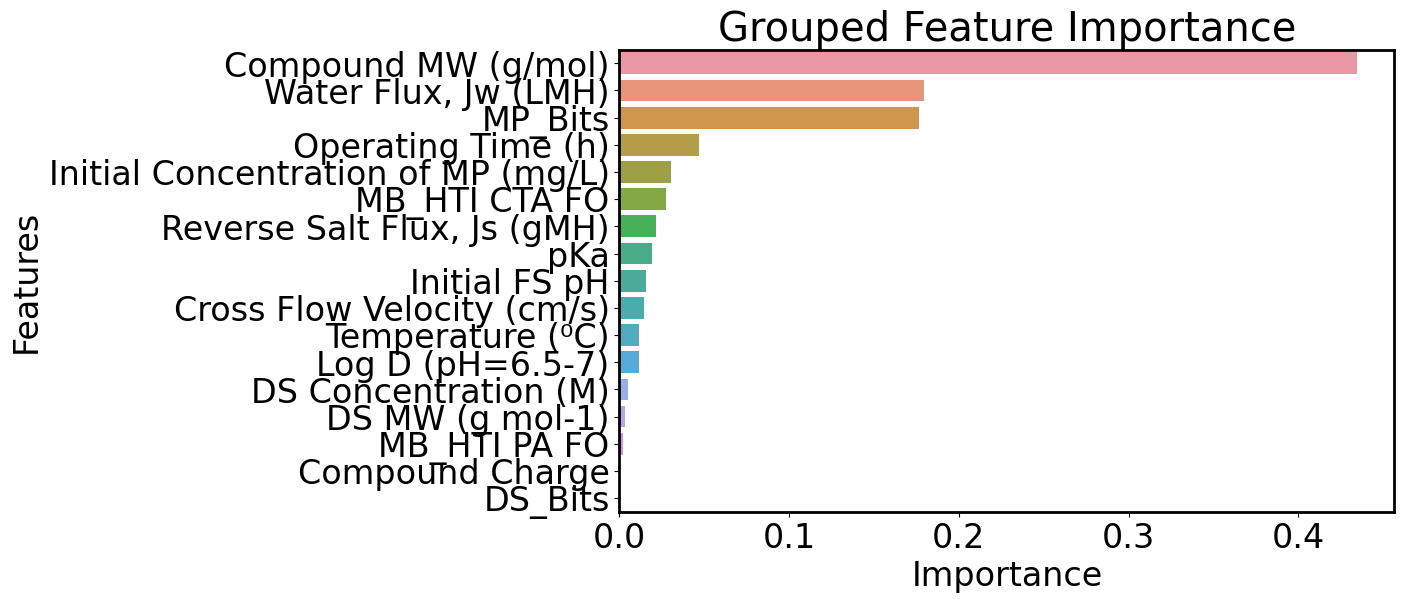

In [38]:

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


# Sample dataset
# Ensure you have the dataset prepared as per your previous preprocessing code

# Custom hyperparameters for GBR
custom_gbr_params = {
    'n_estimators': 2000,      # Adjust the number of estimators
    'max_depth': 8,            # Adjust the max depth of trees
    'learning_rate': 0.08,     # Adjust the learning rate
    'subsample': 0.8,          # Adjust the subsample size
    'min_samples_split': 8,    # Adjust the min_samples_split
    'min_samples_leaf': 2,     # Adjust the min_samples_leaf
    'alpha': 0.5               # Adjust the regularization (alpha)
}

# Import KFold for 9-fold cross-validation
from sklearn.model_selection import KFold

# Define the number of folds (9 in this case)
n_folds = 9

# Initialize KFold with 9 folds
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Create an empty list to store evaluation results for each fold
r2_scores = []
rmse_scores = []
mae_scores = []
mse_scores = []
feature_importances = np.zeros(X.shape[1])  # Initialize to collect feature importances

# Perform 9-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Normalize the features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create an imputer to fill missing values (e.g., with the mean or median)
    imputer = SimpleImputer(strategy='mean')

    # Create a pipeline that includes imputation and regression with custom GBR hyperparameters
    pipeline = Pipeline([
        ('imputer', imputer),
        ('regressor', GradientBoostingRegressor(**custom_gbr_params))  # Pass custom hyperparameters here
    ])

    # Fit the pipeline to your data
    pipeline.fit(X_train_scaled, y_train)

    # Make predictions using the model
    y_pred = pipeline.predict(X_test_scaled)

    # Calculate evaluation metrics for each fold
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Append the scores to the respective lists
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mse_scores.append(mse)

    # Collect feature importances
    feature_importances += pipeline.named_steps['regressor'].feature_importances_




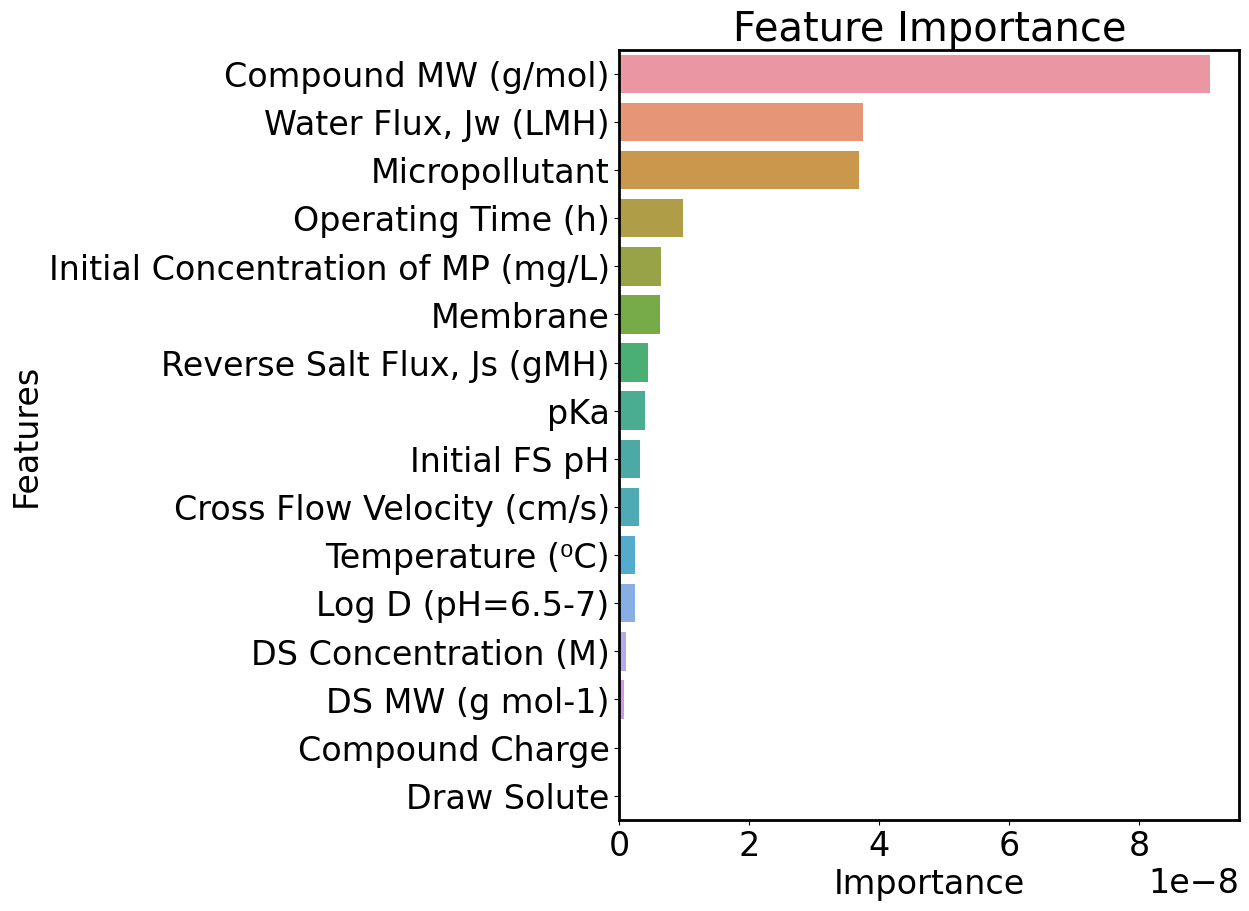

In [45]:
# Average feature importances
feature_importances /= n_folds

# Grouping feature importances by original feature names
ds_bit_columns = [col for col in X.columns if col.startswith('DS_Bit_')]
mp_bit_columns = [col for col in X.columns if col.startswith('MP_Bit_')]
mb_columns = [col for col in X.columns if col.startswith('MB_')]

other_features = [col for col in X.columns if not (col.startswith('DS_Bit_') or col.startswith('MP_Bit_') or col.startswith('MB_'))]

grouped_feature_importances = {
    'Draw Solute': feature_importances[[X.columns.get_loc(col) for col in ds_bit_columns]].sum(),
    'Micropollutant': feature_importances[[X.columns.get_loc(col) for col in mp_bit_columns]].sum(),
    'Membrane': feature_importances[[X.columns.get_loc(col) for col in mb_columns]].sum()

}

# Add importances for other features
for feature in other_features:
    grouped_feature_importances[feature] = feature_importances[X.columns.get_loc(feature)]

# Convert the dictionary to a sorted list of tuples
grouped_feature_importances = sorted(grouped_feature_importances.items(), key=lambda x: x[1], reverse=True)

# Plot grouped feature importances
feature_names, importances = zip(*grouped_feature_importances)

plt.figure(figsize=(8, 10))
sns.barplot(x=list(importances), y=list(feature_names))
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

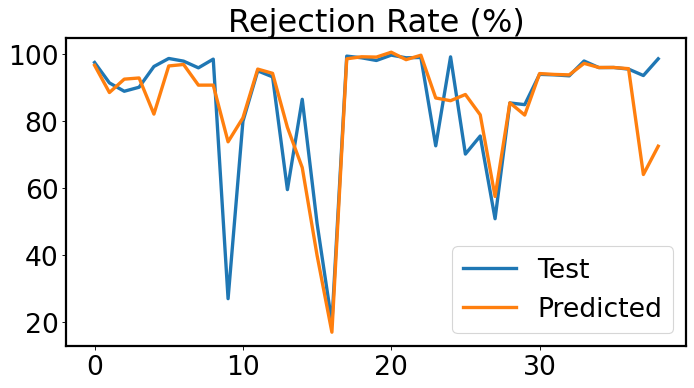

NameError: name 'axes' is not defined

In [30]:
plt.rcParams.update({'font.size': 24, 'lines.linewidth': 3, 'axes.linewidth': 2})

plt.figure(figsize=(10, 5), dpi=80)
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Test")
plt.plot(x_ax, y_pred, label="Predicted")
plt.title("Rejection Rate (%)")
plt.legend()
plt.show()
for ax in axes:
    ax.tick_params(axis='both', which='both', direction='in', width=3, length=5)
    ax.xaxis.set_tick_params(width=3)
    ax.yaxis.set_tick_params(width=3)
    for spine in ax.spines.values():
        spine.set_linewidth(4)

plt.tight_layout()
plt.show()

In [31]:
feature_importance = reg_mod.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

NameError: name 'reg_mod' is not defined

In [46]:
#explainer = shap.Explainer(pipeline.named_steps['regressor'])

# Calculate SHAP values
#shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot
#shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


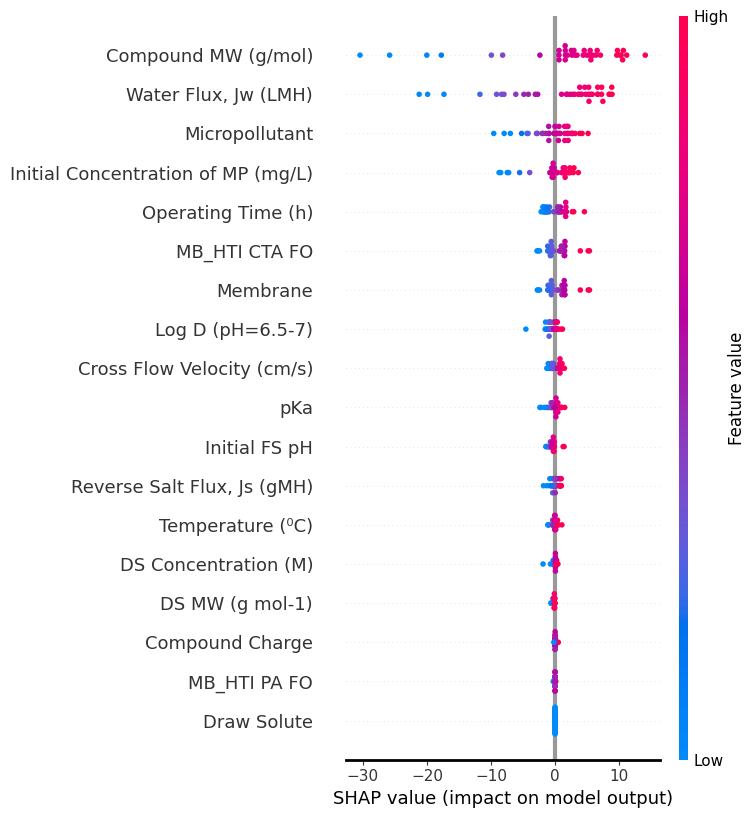

In [55]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your trained model is stored in the 'pipeline' variable

# Create a SHAP explainer for your model
explainer = shap.Explainer(pipeline.named_steps['regressor'])

# Calculate SHAP values for your test data
shap_values = explainer.shap_values(X_test_scaled)

# Create a DataFrame for SHAP values
shap_df = pd.DataFrame(shap_values, columns=X.columns)

# Grouping SHAP values by original feature names
ds_bit_columns = [col for col in X.columns if col.startswith('DS_Bit_')]
mp_bit_columns = [col for col in X.columns if col.startswith('MP_Bit_')]
mb_columns = [col for col in X.columns if col.startswith('MB_')]

other_features = [col for col in X.columns if not (col.startswith('DS_Bit_') or col.startswith('MP_Bit_'))]

# Summing SHAP values for each group for each instance
shap_df['Draw Solute'] = shap_df[ds_bit_columns].sum(axis=1)
shap_df['Micropollutant'] = shap_df[mp_bit_columns].sum(axis=1)
shap_df['Membrane'] = shap_df[mb_columns].sum(axis=1)

# Create a DataFrame for the grouped SHAP values
grouped_shap_df = shap_df[['Draw Solute', 'Micropollutant','Membrane'] + other_features]

# Calculate mean absolute SHAP values for each group
grouped_shap_means = grouped_shap_df.abs().mean().sort_values(ascending=False)

# Sort grouped SHAP values DataFrame columns by mean absolute SHAP values
sorted_columns = grouped_shap_means.index
grouped_shap_df = grouped_shap_df[sorted_columns]

# Plot scatter plots for the grouped SHAP values with color coding for feature values
plt.figure(figsize=(12, 8))
shap.summary_plot(grouped_shap_df.values, grouped_shap_df, feature_names=grouped_shap_df.columns, plot_type='dot')
#plt.title("Grouped SHAP Values Scatter Plot with Color Coding")
plt.show()
